Realize a Reinforcement Learning implementation of a self-learning BlackJack player in a programming language of your choice. This implementation provides the basis for the paper from Task P3.2. It shall learn optimal policies for at least the following scenarios:
1.	The Basic Strategy from [3].
2.	The Complete Point-Count System from [3].
3.	In addition to the basic rules, two rule variations of your choice shall be examined for their influence on the strategies from (1.) and (2.).
4.	Consider improving the system from (2.) to be able to achieve higher pro ts on average.Note: Your system does not have to be suitable for humans. It may therefore be relatively complicated, e.g. with respect to card counting.
What pro t can be expected for the different scenarios?

You can re-use your previous implementations from the Reinforcement Learning exercises. For example, the environment implementation from the Chapter 3 exercises.
The deliverable for this task is the commented source code of your implementation and all log les that contributed to the results in Task P3.2. Do not use an external Reinforcement Learning framework.

# **Basic Strategy without Q-Learning**

In [2]:
import random

# Define card values and initialize deck
card_values = {'A': 11, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10}
cards = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
deck = cards * 4
random.shuffle(deck)

def check_total(hand):
    """ Calculate the total of the hand with the possibility to adjust Ace's value """
    total = sum(card_values[card] for card in hand)
    aces = hand.count('A')
    while total > 21 and aces:
        total -= 10
        aces -= 1
    return total

def deal_card(deck, hand):
    """ Deal a card from the deck to a hand """
    hand.append(deck.pop())

def print_hand(context, hand, hidden=False):
    """ Print the hand. If hidden is True, hide the second card """
    if hidden:
        print(f"{context} cards: {hand[0]} + hidden")
    else:
        print(f"{context} cards: {hand}")

def play_hand(deck, hand):
    """ Play a hand for the player """
    while True:
        if check_total(hand) == 21:
            print('Black Jack!')
            return 21, hand
        elif check_total(hand) > 21:
            print('You Bust!')
            return check_total(hand), hand

        action = input('Hit(H), Stay(S), Double Down(D) or Split(P)? ')
        if action.upper() == 'H':
            deal_card(deck, hand)
            print_hand("Your", hand)
        elif action.upper() == 'S':
            return check_total(hand), hand
        elif action.upper() == 'D':
            deal_card(deck, hand)
            print_hand("Your", hand)
            return check_total(hand), hand
        elif action.upper() == 'P' and len(hand) == 2 and hand[0] == hand[1]:
            hand1 = [hand[0]]
            hand2 = [hand[1]]
            deal_card(deck, hand1)
            deal_card(deck, hand2)
            print("Playing first split hand:")
            score1, hand1 = play_hand(deck, hand1)
            print("Playing second split hand:")
            score2, hand2 = play_hand(deck, hand2)
            return max(score1, score2), hand1 if score1 > score2 else hand2
        else:
            print("Invalid action. Please choose again.")

def dealer_turn(deck, dealer):
    """ Dealer's turn to play """
    print_hand("Dealer's", dealer, hidden=False)
    return check_total(dealer)

def main():
    # Initialize player and dealer hands
    dealer = []
    player = []
    reward = 0

    # Initial distribution of the cards
    deal_card(deck, player)
    deal_card(deck, player)
    deal_card(deck, dealer)
    deal_card(deck, dealer)

    print_hand("Dealer's", dealer, hidden=True)
    print_hand("Your", player)

    # Player's turn
    player_total, player_hand = play_hand(deck, player)

    if player_total > 21:
        print('You Bust, Dealer won!!')
        reward = -10
    else:
        # Dealer's turn
        dealer_total = dealer_turn(deck, dealer)

        if dealer_total > 21:
            print('Dealer Bust, You won!!')
            reward = 10
        else:
            # Compare hands
            if player_total > dealer_total:
                print('You won!!')
                reward = 10
            else:
                print('Dealer won!!')
                reward = -10

    print(f'Reward: {reward}')

if __name__ == '__main__':
    main()


Dealer's cards: 4 + hidden
Your cards: ['2', '6']
Hit(H), Stay(S), Double Down(D) or Split(P)? H
Your cards: ['2', '6', 'A']
Hit(H), Stay(S), Double Down(D) or Split(P)? H
Your cards: ['2', '6', 'A', '2']
Black Jack!
Dealer's cards: ['4', '3']
You won!!
Reward: 10


# **Basic Strategy with Q-Learning - Mimicking the Dealer**






Training agent...
Episode 0/500000 - Win percentage: 29.70% - Exploration rate: 0.9995, Learning rate: 0.0100
Episode 10000/500000 - Win percentage: 39.10% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 20000/500000 - Win percentage: 37.90% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 30000/500000 - Win percentage: 44.10% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 40000/500000 - Win percentage: 41.60% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 50000/500000 - Win percentage: 38.10% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 60000/500000 - Win percentage: 42.60% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 70000/500000 - Win percentage: 40.70% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 80000/500000 - Win percentage: 40.40% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 90000/500000 - Win percentage: 39.50% - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 100000/500000 - Wi

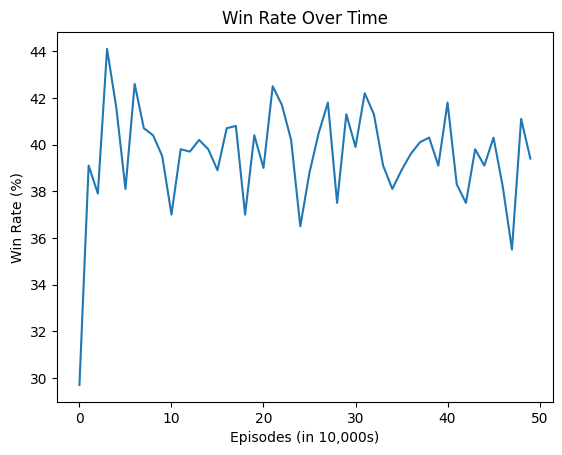

Evaluating agent...
Wins: 400, Losses: 514, Draws: 86
Winning Percentage: 40.00%


In [21]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Define card values and initialize deck
card_values = {'A': 11, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10}
cards = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']

def create_deck(num_decks=6):
    deck = cards * 4 * num_decks
    random.shuffle(deck)
    return deck

def deal_card(deck, hand):
    """ Deal a card from the deck to a hand """
    hand.append(deck.pop())

def check_total(hand):
    """ Calculate the total of the hand with the possibility to adjust Ace's value """
    total = sum(card_values[card] for card in hand)
    ace_count = hand.count('A')
    while total > 21 and ace_count:
        total -= 10
        ace_count -= 1
    return total

class BlackjackEnv:
    def __init__(self):
        self.deck = create_deck()
        self.dealer = []
        self.player = []
        self.bet = 1

    def reset(self):
        self.deck = create_deck()
        self.dealer = []
        self.player = []
        self.bet = 1
        deal_card(self.deck, self.player)
        deal_card(self.deck, self.player)
        deal_card(self.deck, self.dealer)
        deal_card(self.deck, self.dealer)
        return self.get_state()

    def get_state(self):
        player_total = check_total(self.player)
        dealer_up_card = card_values[self.dealer[0]]
        player_ace = 'A' in self.player
        dealer_ace = 'A' in self.dealer
        player_pair = len(self.player) == 2 and self.player[0] == self.player[1]
        return (player_total, dealer_up_card, player_ace, dealer_ace, player_pair, len(self.player))

    def step(self, action):
        if action == 'H':
            deal_card(self.deck, self.player)
            player_total = check_total(self.player)
            if player_total > 21:
                return self.get_state(), -10, True, {}  # Player busts
            elif player_total == 21:
                return self.get_state(), 5, False, {}  # Player hits 21
            else:
                return self.get_state(), 0, False, {}
        elif action == 'S':
            while check_total(self.dealer) < 17:
                deal_card(self.deck, self.dealer)
            dealer_total = check_total(self.dealer)
            player_total = check_total(self.player)
            if dealer_total > 21 or player_total > dealer_total:
                return self.get_state(), 10, True, {}  # Dealer busts or player wins
            elif player_total < dealer_total:
                return self.get_state(), -10, True, {}  # Dealer wins
            else:
                return self.get_state(), 0, True, {}  # Draw
        elif action == 'M':  # Mimic strategy
            while check_total(self.player) < 17:
                deal_card(self.deck, self.player)
            player_total = check_total(self.player)
            if player_total > 21:
                return self.get_state(), -10, True, {}  # Player busts
            while check_total(self.dealer) < 17:
                deal_card(self.deck, self.dealer)
            dealer_total = check_total(self.dealer)
            if dealer_total > 21 or player_total > dealer_total:
                return self.get_state(), 10, True, {}  # Dealer busts or player wins
            elif player_total < dealer_total:
                return self.get_state(), -10, True, {}  # Dealer wins
            else:
                return self.get_state(), 0, True, {}  # Draw

    def valid_actions(self):
        return ['H', 'S', 'M']  # Include Mimic action

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, learning_rate=0.01, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.9995, min_exploration_rate=0.01):
        self.q_table = defaultdict(lambda: np.zeros(3))  # Three actions: Hit (H), Stand (S), Mimic (M)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

    def choose_action(self, state, valid_actions):
        if random.random() < self.exploration_rate:
            return random.choice(valid_actions)
        else:
            action_indices = {'H': 0, 'S': 1, 'M': 2}
            valid_indices = [action_indices[action] for action in valid_actions]
            q_values = self.q_table[state]
            valid_q_values = [q_values[index] for index in valid_indices]
            max_q_value_index = valid_indices[np.argmax(valid_q_values)]
            return {0: 'H', 1: 'S', 2: 'M'}[max_q_value_index]

    def learn(self, state, action, reward, next_state):
        action_idx = {'H': 0, 'S': 1, 'M': 2}[action]
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action_idx]
        self.q_table[state][action_idx] += self.learning_rate * td_error

    def update_exploration_rate(self):
        self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

    def update_learning_rate(self, episode, total_episodes):
        self.learning_rate = max(0.01, self.learning_rate * (1 - episode / total_episodes))

def train_agent(env, agent, episodes=500000):
    win_rate_history = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            valid_actions = env.valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
        agent.update_exploration_rate()
        agent.update_learning_rate(episode, episodes)
        if episode % 10000 == 0:
            wins, losses, draws = evaluate_agent(env, agent, 1000)
            win_percentage = (wins / 1000) * 100
            win_rate_history.append(win_percentage)
            print(f'Episode {episode}/{episodes} - Win percentage: {win_percentage:.2f}% - Exploration rate: {agent.exploration_rate:.4f}, Learning rate: {agent.learning_rate:.4f}')
    return win_rate_history

def evaluate_agent(env, agent, num_eval_episodes):
    wins, losses, draws = 0, 0, 0
    for _ in range(num_eval_episodes):
        state = env.reset()
        done = False
        while not done:
            valid_actions = env.valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done, _ = env.step(action)
            state = next_state
        if reward > 0:
            wins += 1
        elif reward < 0:
            losses += 1
        else:
            draws += 1
    return wins, losses, draws

# Main function to train and evaluate the agent
def main():
    env = BlackjackEnv()
    agent = QLearningAgent()

    print("Training agent...")
    win_rate_history = train_agent(env, agent, episodes=500000)

    # Plotting the win rate history
    plt.plot(range(len(win_rate_history)), win_rate_history)
    plt.xlabel('Episodes (in 10,000s)')
    plt.ylabel('Win Rate (%)')
    plt.title('Win Rate Over Time')
    plt.show()

    # Evaluate the trained agent
    print("Evaluating agent...")
    wins, losses, draws = evaluate_agent(env, agent, 1000)
    win_percentage = (wins / 1000) * 100
    print(f'Wins: {wins}, Losses: {losses}, Draws: {draws}')
    print(f'Winning Percentage: {win_percentage:.2f}%')

if __name__ == '__main__':
    main()


# **Complete point count**

Training agent...
Episode 0/200000 - Exploration rate: 0.9995, Learning rate: 0.1000
Episode 10000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 20000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 30000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 40000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 50000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 60000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 70000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 80000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 90000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 100000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 110000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 120000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 130000/200000 - Exploration rate: 0.0100, Learning r

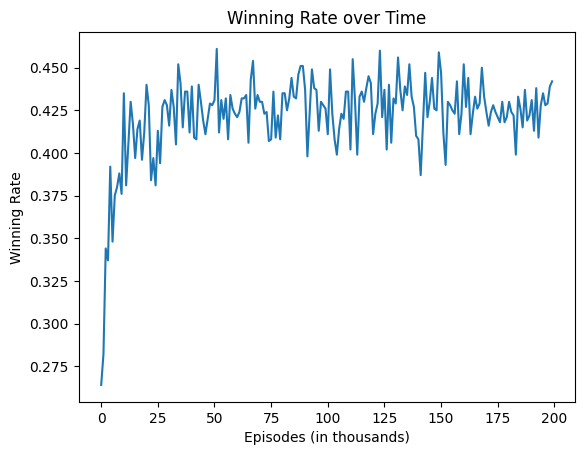

In [ ]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Define card values and initialize deck
card_values = {'A': 11, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10}
cards = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']

def create_deck(num_decks=6):
    deck = cards * 4 * num_decks
    random.shuffle(deck)
    return deck

def deal_card(deck, hand):
    """ Deal a card from the deck to a hand """
    card = deck.pop()
    hand.append(card)
    return card

def check_total(hand):
    """ Calculate the total of the hand with the possibility to adjust Ace's value """
    total = sum(card_values[card] for card in hand)
    ace_count = hand.count('A')
    while total > 21 and ace_count:
        total -= 10
        ace_count -= 1
    return total

def is_soft_hand(hand):
    """ Check if the hand is a soft hand """
    total = sum(card_values[card] for card in hand)
    ace_count = hand.count('A')
    return ace_count > 0 and total <= 21

def update_point_count(card, point_count):
    """ Update point count based on the card dealt """
    if card in ['2', '3', '4', '5', '6']:
        point_count += 1
    elif card in ['10', 'J', 'Q', 'K', 'A']:
        point_count -= 1
    return point_count

class BlackjackEnv:
    def __init__(self):
        self.deck = create_deck()
        self.dealer = []
        self.player = []
        self.point_count = 0

    def reset(self):
        self.deck = create_deck()
        self.dealer = []
        self.player = []
        self.point_count = 0
        player_card1 = deal_card(self.deck, self.player)
        player_card2 = deal_card(self.deck, self.player)
        dealer_card1 = deal_card(self.deck, self.dealer)
        dealer_card2 = deal_card(self.deck, self.dealer)
        self.point_count = update_point_count(player_card1, self.point_count)
        self.point_count = update_point_count(player_card2, self.point_count)
        self.point_count = update_point_count(dealer_card1, self.point_count)
        self.point_count = update_point_count(dealer_card2, self.point_count)
        return self.get_state()

    def get_state(self):
        player_total = check_total(self.player)
        dealer_up_card = card_values[self.dealer[0]]
        soft_hand = is_soft_hand(self.player)
        return (player_total, dealer_up_card, soft_hand, len(self.player), self.point_count)

    def step(self, action):
        if action == 'H':
            card = deal_card(self.deck, self.player)
            self.point_count = update_point_count(card, self.point_count)
            player_total = check_total(self.player)
            if player_total > 21:
                return self.get_state(), -1, True, {}  # Player busts
            else:
                return self.get_state(), 0, False, {}
        elif action == 'S':
            while check_total(self.dealer) < 17:
                card = deal_card(self.deck, self.dealer)
                self.point_count = update_point_count(card, self.point_count)
            dealer_total = check_total(self.dealer)
            player_total = check_total(self.player)
            if dealer_total > 21 or player_total > dealer_total:
                return self.get_state(), 1, True, {}  # Dealer busts or player wins
            elif player_total < dealer_total:
                return self.get_state(), -1, True, {}  # Dealer wins
            else:
                return self.get_state(), 0, True, {}  # Draw

    def valid_actions(self):
        return ['H', 'S']

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.9995, min_exploration_rate=0.01):
        self.q_table = defaultdict(lambda: np.zeros(2))  # Two actions: Hit (H) or Stand (S)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

    def choose_action(self, state, valid_actions):
        if random.random() < self.exploration_rate:
            return random.choice(valid_actions)
        else:
            action_indices = {'H': 0, 'S': 1}
            valid_indices = [action_indices[action] for action in valid_actions]
            q_values = self.q_table[state]
            valid_q_values = [q_values[index] for index in valid_indices]
            max_q_value_index = valid_indices[np.argmax(valid_q_values)]
            return {0: 'H', 1: 'S'}[max_q_value_index]

    def learn(self, state, action, reward, next_state):
        action_idx = {'H': 0, 'S': 1}[action]
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action_idx]
        self.q_table[state][action_idx] += self.learning_rate * td_error

    def update_exploration_rate(self):
        self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

    def update_learning_rate(self, episode, total_episodes):
        self.learning_rate = max(0.01, self.learning_rate * (1 - episode / total_episodes))

def train_agent(env, agent, episodes=200000):
    win_history = []
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            valid_actions = env.valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
        agent.update_exploration_rate()
        agent.update_learning_rate(episode, episodes)
        if reward == 1:
            win_history.append(1)
        elif reward == -1:
            win_history.append(-1)
        else:
            win_history.append(0)
        if episode % 10000 == 0:
            print(f'Episode {episode}/{episodes} - Exploration rate: {agent.exploration_rate:.4f}, Learning rate: {agent.learning_rate:.4f}')
    return win_history

def evaluate_agent(env, agent, num_eval_episodes=1000):
    wins, losses, draws = 0, 0, 0
    for _ in range(num_eval_episodes):
        state = env.reset()
        done = False
        while not done:
            valid_actions = env.valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done, _ = env.step(action)
            state = next_state
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_percentage = (wins / num_eval_episodes) * 100
    print(f'Wins: {wins}, Losses: {losses}, Draws: {draws}')
    print(f'Winning Percentage: {win_percentage:.2f}%')

    return wins, losses, draws

def plot_win_history(win_history, num_eval_episodes=1000):
    win_rate = []
    for i in range(0, len(win_history), num_eval_episodes):
        segment = win_history[i:i+num_eval_episodes]
        win_rate.append(segment.count(1) / len(segment))
    plt.plot(win_rate)
    plt.xlabel('Episodes (in thousands)')
    plt.ylabel('Winning Rate')
    plt.title('Winning Rate over Time')
    plt.show()

# Main function to train and evaluate the agent
def main():
    env = BlackjackEnv()
    agent = QLearningAgent()

    print("Training agent...")
    win_history = train_agent(env, agent, episodes=200000)

    print("Evaluating agent...")
    evaluate_agent(env, agent)

    plot_win_history(win_history)

if __name__ == '__main__':
    main()


# **Dealer stands on soft 17 Rule Variation**

Results after 1000 episodes:
Wins: 424, Losses: 218, Ties: 358
Winning percentage: 42.40%


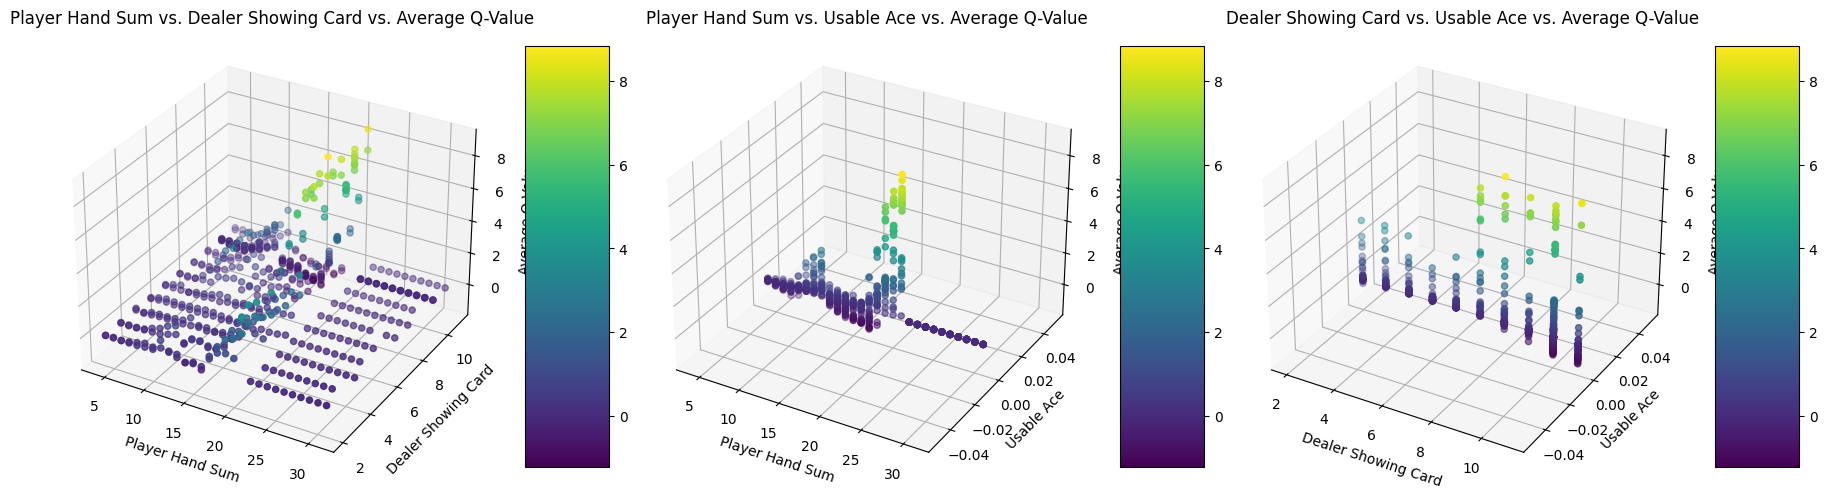

In [13]:
import numpy as np
import random
import gym
from gym import spaces
from gym.utils import seeding
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define constants for the game
CARD_VALUES = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
DECK_SIZE = 6  # Number of decks used in the shoe

class BlackjackEnv(gym.Env):
    def __init__(self):
        self.action_space = spaces.Discrete(2)  # 0 for stick, 1 for hit
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),  # Player's current hand sum (0-31)
            spaces.Discrete(11),  # Dealer's face up card (1-10)
            spaces.Discrete(2),   # Does the player have a usable ace? (0 or 1)
            spaces.Discrete(2)    # Is the game over? (0 or 1)
        ))
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        # Initialize deck and hands
        self.deck = self._init_deck()
        self.player_hand = []
        self.dealer_hand = []

        # Deal initial cards
        self._deal_card(self.player_hand)
        self._deal_card(self.dealer_hand)
        self._deal_card(self.player_hand)

        # Calculate initial state
        player_sum = self._get_hand_sum(self.player_hand)
        dealer_card = self.dealer_hand[0]
        usable_ace = int(self._has_usable_ace(self.player_hand))
        self.state = (player_sum, dealer_card, usable_ace, 0)  # 0 means game is not over

        return np.array(self.state)

    def step(self, action):
        assert self.action_space.contains(action)

        if action == 1:  # Hit
            self._deal_card(self.player_hand)
            player_sum = self._get_hand_sum(self.player_hand)
            usable_ace = int(self._has_usable_ace(self.player_hand))
            if player_sum > 21:
                reward = -2  # Strong penalty for busting
                done = True
            else:
                reward = -0.1  # Small negative reward to encourage ending the game
                done = False
        else:  # Stick
            done = True
            dealer_sum = self._get_hand_sum(self.dealer_hand)

            # Dealer's turn, dealer stands on soft 17
            while dealer_sum < 17 or (dealer_sum == 17 and self._has_usable_ace(self.dealer_hand)):
                self._deal_card(self.dealer_hand)
                dealer_sum = self._get_hand_sum(self.dealer_hand)

            player_sum = self._get_hand_sum(self.player_hand)
            usable_ace = int(self._has_usable_ace(self.player_hand))

            if dealer_sum > 21 or player_sum > dealer_sum:
                reward = 2  # Strong reward for winning
            elif player_sum == dealer_sum:
                reward = 1  # Small reward for a tie
            else:
                reward = -1  # Penalty for losing

        self.state = (player_sum, self.dealer_hand[0], usable_ace, 1)  # Game over
        return np.array(self.state), reward, done, {}

    def _init_deck(self):
        deck = list(CARD_VALUES.keys()) * 4 * DECK_SIZE
        random.shuffle(deck)
        return deck

    def _deal_card(self, hand):
        card = self.deck.pop()
        hand.append(card)

    def _get_hand_sum(self, hand):
        total = sum([CARD_VALUES[card] for card in hand])
        num_aces = sum([1 for card in hand if card == 'A'])

        while total > 21 and num_aces:
            total -= 10
            num_aces -= 1

        return total

    def _has_usable_ace(self, hand):
        total = sum([CARD_VALUES[card] for card in hand])
        num_aces = sum([1 for card in hand if card == 'A'])
        return num_aces > 0 and total + 10 <= 21

# Double Q-learning agent
class DoubleQLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.01, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.999):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table1 = defaultdict(lambda: np.zeros(action_space.n))
        self.q_table2 = defaultdict(lambda: np.zeros(action_space.n))

    def get_action(self, state):
        state = tuple(state)
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()  # Explore
        q_values_sum = self.q_table1[state] + self.q_table2[state]
        return np.argmax(q_values_sum)  # Exploit

    def update_q_table(self, state, action, reward, next_state):
        state = tuple(state)
        next_state = tuple(next_state)
        if np.random.rand() < 0.5:
            best_next_action = np.argmax(self.q_table1[next_state])
            td_target = reward + self.gamma * self.q_table2[next_state][best_next_action]
            td_delta = td_target - self.q_table1[state][action]
            self.q_table1[state][action] += self.lr * td_delta
        else:
            best_next_action = np.argmax(self.q_table2[next_state])
            td_target = reward + self.gamma * self.q_table1[next_state][best_next_action]
            td_delta = td_target - self.q_table2[state][action]
            self.q_table2[state][action] += self.lr * td_delta

    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)

def train_agent(env, agent, num_episodes):
    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state

        agent.decay_epsilon()

def simulate_episodes(env, agent, num_episodes):
    wins, losses, ties = 0, 0, 0

    for _ in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)

        if reward == 2:
            wins += 1
        elif reward == -2:
            losses += 1
        else:
            ties += 1

    total_games = wins + losses + ties
    win_percentage = (wins / total_games) * 100 if total_games > 0 else 0

    print(f"Results after {num_episodes} episodes:")
    print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")
    print(f"Winning percentage: {win_percentage:.2f}%")
    return win_percentage

def plot_q_values(agent):
    states = []
    q_values = []

    for state, action_values1 in agent.q_table1.items():
        action_values2 = agent.q_table2[state]
        avg_q_value = np.mean(action_values1 + action_values2)
        states.append(state)
        q_values.append(avg_q_value)

    states = np.array(states)
    q_values = np.array(q_values)

    # Plot 1: Player Hand Sum vs. Dealer Showing Card vs. Average Q-Value
    player_hand_sum = states[:, 0].astype(float)
    dealer_showing_card = np.array([CARD_VALUES[state[1]] for state in states], dtype=float)

    fig = plt.figure(figsize=(18, 12))

    ax1 = fig.add_subplot(131, projection='3d')
    scatter1 = ax1.scatter(player_hand_sum, dealer_showing_card, q_values, c=q_values, cmap='viridis', marker='o')
    ax1.set_xlabel('Player Hand Sum')
    ax1.set_ylabel('Dealer Showing Card')
    ax1.set_zlabel('Average Q-Value')
    ax1.set_title('Player Hand Sum vs. Dealer Showing Card vs. Average Q-Value')
    fig.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=5)

    # Plot 2: Player Hand Sum vs. Usable Ace vs. Average Q-Value
    usable_ace = states[:, 2].astype(float)

    ax2 = fig.add_subplot(132, projection='3d')
    scatter2 = ax2.scatter(player_hand_sum, usable_ace, q_values, c=q_values, cmap='viridis', marker='o')
    ax2.set_xlabel('Player Hand Sum')
    ax2.set_ylabel('Usable Ace')
    ax2.set_zlabel('Average Q-Value')
    ax2.set_title('Player Hand Sum vs. Usable Ace vs. Average Q-Value')
    fig.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=5)

    # Plot 3: Dealer Showing Card vs. Usable Ace vs. Average Q-Value
    dealer_showing_card = np.array([CARD_VALUES[state[1]] for state in states], dtype=float)

    ax3 = fig.add_subplot(133, projection='3d')
    scatter3 = ax3.scatter(dealer_showing_card, usable_ace, q_values, c=q_values, cmap='viridis', marker='o')
    ax3.set_xlabel('Dealer Showing Card')
    ax3.set_ylabel('Usable Ace')
    ax3.set_zlabel('Average Q-Value')
    ax3.set_title('Dealer Showing Card vs. Usable Ace vs. Average Q-Value')
    fig.colorbar(scatter3, ax=ax3, shrink=0.5, aspect=5)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    env = BlackjackEnv()
    agent = DoubleQLearningAgent(env.observation_space, env.action_space)

    # Train the agent
    train_agent(env, agent, num_episodes=200000)  # Increase the number of training episodes

    # Simulate with the trained agent and print winning percentage
    win_percentage = simulate_episodes(env, agent, num_episodes=1000)

    # Plot the Q-Value distribution
    plot_q_values(agent)


# **Multiple Decks Rule variation**

Results after 1000 episodes:
Wins: 413, Losses: 203, Ties: 384
Winning percentage: 41.30%


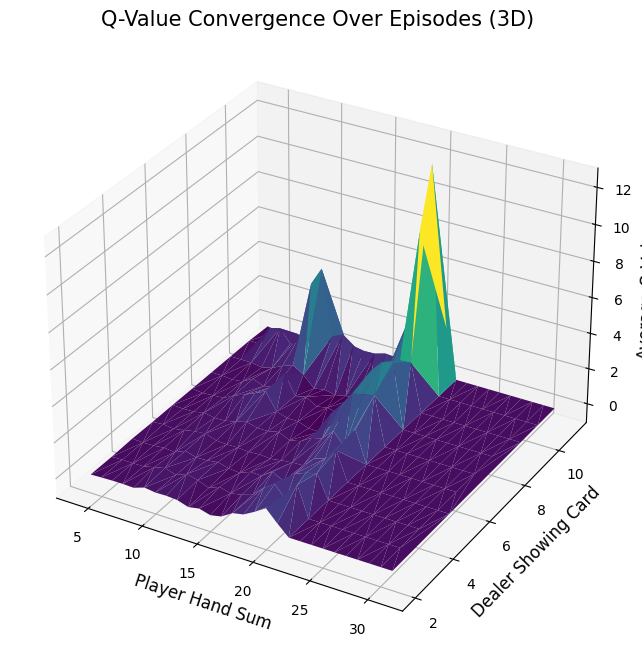

In [13]:
import numpy as np
import random
import gym
from gym import spaces
from gym.utils import seeding
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define constants for the game
CARD_VALUES = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}

class BlackjackEnv(gym.Env):
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.action_space = spaces.Discrete(2)  # 0 for stick, 1 for hit
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),  # Player's current hand sum (0-31)
            spaces.Discrete(11),  # Dealer's face up card (1-10)
            spaces.Discrete(2),   # Does the player have a usable ace? (0 or 1)
            spaces.Discrete(2)    # Is the game over? (0 or 1)
        ))
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def reset(self):
        # Initialize deck and hands
        self.deck = self._init_deck()
        self.player_hand = []
        self.dealer_hand = []

        # Deal initial cards
        self._deal_card(self.player_hand)
        self._deal_card(self.dealer_hand)
        self._deal_card(self.player_hand)

        # Calculate initial state
        player_sum = self._get_hand_sum(self.player_hand)
        dealer_card = self.dealer_hand[0]
        usable_ace = int(self._has_usable_ace(self.player_hand))
        self.state = (player_sum, CARD_VALUES[dealer_card], usable_ace, 0)  # 0 means game is not over

        return np.array(self.state)

    def step(self, action):
        assert self.action_space.contains(action)

        if action == 1:  # Hit
            self._deal_card(self.player_hand)
            player_sum = self._get_hand_sum(self.player_hand)
            usable_ace = int(self._has_usable_ace(self.player_hand))
            if player_sum > 21:
                reward = -2  # Increased penalty for busting
                done = True
            else:
                reward = -0.1  # Small negative reward to encourage ending the game
                done = False
        else:  # Stick
            done = True
            while self._get_hand_sum(self.dealer_hand) < 17:
                self._deal_card(self.dealer_hand)

            player_sum = self._get_hand_sum(self.player_hand)
            dealer_sum = self._get_hand_sum(self.dealer_hand)
            usable_ace = int(self._has_usable_ace(self.player_hand))

            if dealer_sum > 21 or player_sum > dealer_sum:
                reward = 2  # Increased reward for winning
            elif player_sum == dealer_sum:
                reward = 1  # Small reward for a tie
            else:
                reward = -1  # Small penalty for losing

        self.state = (player_sum, CARD_VALUES[self.dealer_hand[0]], usable_ace, 1)  # Game over
        return np.array(self.state), reward, done, {}

    def _init_deck(self):
        deck = list(CARD_VALUES.keys()) * 4 * self.num_decks
        random.shuffle(deck)
        return deck

    def _deal_card(self, hand):
        card = self.deck.pop()
        hand.append(card)

    def _get_hand_sum(self, hand):
        total = sum([CARD_VALUES[card] for card in hand])
        num_aces = sum([1 for card in hand if card == 'A'])

        while total > 21 and num_aces:
            total -= 10
            num_aces -= 1

        return total

    def _has_usable_ace(self, hand):
        total = sum([CARD_VALUES[card] for card in hand])
        num_aces = sum([1 for card in hand if card == 'A'])
        return num_aces > 0 and total + 10 <= 21

# Q-learning agent
class QLearningAgent:
    def __init__(self, state_space, action_space, learning_rate=0.01, discount_factor=0.95, exploration_rate=1.0, exploration_decay=0.999):
        self.state_space = state_space
        self.action_space = action_space
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.epsilon_decay = exploration_decay
        self.q_table = defaultdict(lambda: np.zeros(action_space.n))

    def get_action(self, state):
        state = tuple(state)
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def update_q_table(self, state, action, reward, next_state):
        state = tuple(state)
        next_state = tuple(next_state)
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_delta

    def decay_epsilon(self):
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)

def train_agent(env, agent, num_episodes):
    for episode in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state

        agent.decay_epsilon()

def simulate_episodes(env, agent, num_episodes):
    wins, losses, ties = 0, 0, 0

    for _ in range(num_episodes):
        state = env.reset()
        done = False

        while not done:
            action = agent.get_action(state)
            state, reward, done, _ = env.step(action)

        if reward == 2:
            wins += 1
        elif reward == -2:
            losses += 1
        else:
            ties += 1

    total_games = wins + losses + ties
    win_percentage = (wins / total_games) * 100 if total_games > 0 else 0

    print(f"Results after {num_episodes} episodes:")
    print(f"Wins: {wins}, Losses: {losses}, Ties: {ties}")
    print(f"Winning percentage: {win_percentage:.2f}%")
    return win_percentage

def plot_q_values(agent):
    states = []
    q_values = []

    for state, action_values in agent.q_table.items():
        avg_q_value = np.mean(action_values)
        states.append(state)
        q_values.append(avg_q_value)

    # Convert to numerical values for plotting
    player_hand_sum = np.array([state[0] for state in states], dtype=float)
    dealer_showing_card = np.array([state[1] for state in states], dtype=float)
    q_values = np.array(q_values, dtype=float)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    X = player_hand_sum
    Y = dealer_showing_card
    Z = q_values

    ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none')

    ax.set_xlabel('Player Hand Sum', fontsize=12)
    ax.set_ylabel('Dealer Showing Card', fontsize=12)
    ax.set_zlabel('Average Q-Value', fontsize=12)
    ax.set_title('Q-Value Convergence Over Episodes (3D)', fontsize=15)

    plt.show()

if __name__ == "__main__":
    env = BlackjackEnv(num_decks=6)
    agent = QLearningAgent(env.observation_space, env.action_space)

    # Train the agent
    train_agent(env, agent, num_episodes=100000)  # Increased training episodes

    # Simulate with the trained agent and print winning percentage
    win_percentage = simulate_episodes(env, agent, num_episodes=1000)

    # Plot the Q-Value distribution
    plot_q_values(agent)


# **KO**

Training agent...
Episode 0/200000 - Exploration rate: 0.9995, Learning rate: 0.1000
Episode 10000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 20000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 30000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 40000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 50000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 60000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 70000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 80000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 90000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 100000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 110000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 120000/200000 - Exploration rate: 0.0100, Learning rate: 0.0100
Episode 130000/200000 - Exploration rate: 0.0100, Learning r

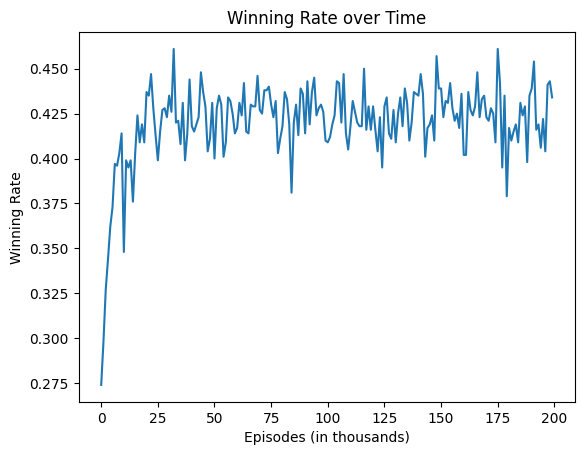

In [7]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

# Define card values and initialize deck
card_values = {'A': 11, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10}
cards = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']

def create_deck(num_decks=6):
    deck = cards * 4 * num_decks
    random.shuffle(deck)
    return deck

def deal_card(deck, hand):
    """ Deal a card from the deck to a hand """
    card = deck.pop()
    hand.append(card)
    return card

def check_total(hand):
    """ Calculate the total of the hand with the possibility to adjust Ace's value """
    total = sum(card_values[card] for card in hand)
    ace_count = hand.count('A')
    while total > 21 and ace_count:
        total -= 10
        ace_count -= 1
    return total

def is_soft_hand(hand):
    """ Check if the hand is a soft hand """
    total = sum(card_values[card] for card in hand)
    ace_count = hand.count('A')
    return ace_count > 0 and total <= 21

def update_point_count(card, point_count):
    """ Update point count based on the KO counting system """
    if card in ['2', '3', '4', '5', '6', '7']:
        point_count += 1
    elif card in ['10', 'J', 'Q', 'K', 'A']:
        point_count -= 1
    return point_count

class BlackjackEnv:
    def __init__(self):
        self.deck = create_deck()
        self.dealer = []
        self.player = []
        self.point_count = 0

    def reset(self):
        self.deck = create_deck()
        self.dealer = []
        self.player = []
        self.point_count = 0
        player_card1 = deal_card(self.deck, self.player)
        player_card2 = deal_card(self.deck, self.player)
        dealer_card1 = deal_card(self.deck, self.dealer)
        dealer_card2 = deal_card(self.deck, self.dealer)
        self.point_count = update_point_count(player_card1, self.point_count)
        self.point_count = update_point_count(player_card2, self.point_count)
        self.point_count = update_point_count(dealer_card1, self.point_count)
        self.point_count = update_point_count(dealer_card2, self.point_count)
        return self.get_state()

    def get_state(self):
        player_total = check_total(self.player)
        dealer_up_card = card_values[self.dealer[0]]
        soft_hand = is_soft_hand(self.player)
        return (player_total, dealer_up_card, soft_hand, len(self.player), self.point_count)

    def step(self, action):
        if action == 'H':
            card = deal_card(self.deck, self.player)
            self.point_count = update_point_count(card, self.point_count)
            player_total = check_total(self.player)
            if player_total > 21:
                return self.get_state(), -1, True, {}  # Player busts
            else:
                return self.get_state(), 0, False, {}
        elif action == 'S':
            while check_total(self.dealer) < 17:
                card = deal_card(self.deck, self.dealer)
                self.point_count = update_point_count(card, self.point_count)
            dealer_total = check_total(self.dealer)
            player_total = check_total(self.player)
            if dealer_total > 21 or player_total > dealer_total:
                return self.get_state(), 1, True, {}  # Dealer busts or player wins
            elif player_total < dealer_total:
                return self.get_state(), -1, True, {}  # Dealer wins
            else:
                return self.get_state(), 0, True, {}  # Draw

    def valid_actions(self):
        return ['H', 'S']

# Q-Learning Agent
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.99, exploration_rate=1.0, exploration_decay=0.9995, min_exploration_rate=0.01):
        self.q_table = defaultdict(lambda: np.zeros(2))  # Two actions: Hit (H) or Stand (S)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate

    def choose_action(self, state, valid_actions):
        if random.random() < self.exploration_rate:
            return random.choice(valid_actions)
        else:
            action_indices = {'H': 0, 'S': 1}
            valid_indices = [action_indices[action] for action in valid_actions]
            q_values = self.q_table[state]
            valid_q_values = [q_values[index] for index in valid_indices]
            max_q_value_index = valid_indices[np.argmax(valid_q_values)]
            return {0: 'H', 1: 'S'}[max_q_value_index]

    def learn(self, state, action, reward, next_state):
        action_idx = {'H': 0, 'S': 1}[action]
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action_idx]
        self.q_table[state][action_idx] += self.learning_rate * td_error

    def update_exploration_rate(self):
        self.exploration_rate = max(self.min_exploration_rate, self.exploration_rate * self.exploration_decay)

    def update_learning_rate(self, episode, total_episodes):
        self.learning_rate = max(0.01, self.learning_rate * (1 - episode / total_episodes))

def train_agent(env, agent, episodes=200000):
    win_history = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            valid_actions = env.valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done, _ = env.step(action)
            agent.learn(state, action, reward, next_state)
            state = next_state
        agent.update_exploration_rate()
        agent.update_learning_rate(episode, episodes)

        if reward == 1:
            win_history.append(1)
        elif reward == -1:
            win_history.append(-1)
        else:
            win_history.append(0)

        if episode % 10000 == 0:
            print(f'Episode {episode}/{episodes} - Exploration rate: {agent.exploration_rate:.4f}, Learning rate: {agent.learning_rate:.4f}')

    return win_history

def evaluate_agent(env, agent, num_eval_episodes=1000):
    wins, losses, draws = 0, 0, 0
    for _ in range(num_eval_episodes):
        state = env.reset()
        done = False
        while not done:
            valid_actions = env.valid_actions()
            action = agent.choose_action(state, valid_actions)
            next_state, reward, done, _ = env.step(action)
            state = next_state
        if reward == 1:
            wins += 1
        elif reward == -1:
            losses += 1
        else:
            draws += 1

    win_percentage = (wins / num_eval_episodes) * 100
    print(f'Wins: {wins}, Losses: {losses}, Draws: {draws}')
    print(f'Winning Percentage: {win_percentage:.2f}%')

    return wins, losses, draws

def plot_win_history(win_history, num_eval_episodes=1000):
    win_rate = []
    for i in range(0, len(win_history), num_eval_episodes):
        segment = win_history[i:i+num_eval_episodes]
        win_rate.append(segment.count(1) / len(segment))
    plt.plot(win_rate)
    plt.xlabel('Episodes (in thousands)')
    plt.ylabel('Winning Rate')
    plt.title('Winning Rate over Time')
    plt.show()

# Main function to train and evaluate the agent
def main():
    env = BlackjackEnv()
    agent = QLearningAgent()

    print("Training agent...")
    win_history = train_agent(env, agent, episodes=200000)

    print("Evaluating agent...")
    evaluate_agent(env, agent)

    plot_win_history(win_history)

if __name__ == '__main__':
    main()
